# Network Construction Guide

This notebook covers the first step in a BioNeuralNet workflow: converting a multi-omics data table (subjects in rows, features in columns) into a multi-omics network that can be fed directly into BioNeuralNet's Graph Neural Network module for embedding generation.

**Why start with networks?**

- Networks capture complex relationships and hidden structure in high-dimensional omics data better than raw tables.
- BioNeuralNet includes several network construction methods (similarity, correlation, soft thresholding, Gaussian k-NN, Lasso, MST, SNN, SmCCNet) allowing you to select the best method for your data and analysis goals.
- The output from each method is a `D × D` adjacency matrix (`D` = number of features), ready for embedding and further downstream tasks.

In this notebook we will:

1. Install `BioNeuralNet` and its core dependencies
2. Load a sample multi-omics dataset
3. Constructing a multi-omics networks
    - Perform basic checks (shape, sparsity) and visualize the networks


## 1. Install `BioNeuralNet` and its core dependencies

A detailed installation guide is availble [here](https://bioneuralnet.readthedocs.io/en/latest/installation.html).

```bash
!pip install bioneuralnet
!pip install torch
!pip install torch-geometric
```

In [ ]:
# Network Construction
from bioneuralnet.utils import gen_similarity_graph
from bioneuralnet.utils import gen_correlation_graph
from bioneuralnet.utils import gen_threshold_graph
from bioneuralnet.utils import gen_mst_graph
from bioneuralnet.utils import gen_snn_graph
from bioneuralnet.external_tools import SmCCNet

# Network Pruning Utilities
from bioneuralnet.utils import prune_network
from bioneuralnet.utils import prune_network_by_quantile
from bioneuralnet.utils import network_remove_low_variance
from bioneuralnet.utils import network_remove_high_zero_fraction

# Network Visualization
from bioneuralnet.metrics import plot_network

## 2. Load a sample multi-omics dataset
Full description of the `TCGA-BRCA`(Breast Cancer) dataset and preprocessing details available [here](https://bioneuralnet.readthedocs.io/en/latest/TCGA-BRCA_Dataset.html).

In [2]:
import time
import pandas as pd
from bioneuralnet.datasets import DatasetLoader

tgca_brca = DatasetLoader("brca")
brca_meth = tgca_brca.data["meth"]
brca_rna = tgca_brca.data["rna"]
brca_mirna = tgca_brca.data["mirna"]
brca_clinical = tgca_brca.data["clinical"]
brca_pam50 = tgca_brca.data["pam50"]
print(tgca_brca.shape)

# Display the first few rows of the datasets
display(brca_meth.iloc[:5,:5])
display(brca_rna.iloc[:5,:5])
display(brca_mirna.iloc[:5,:5])
display(brca_clinical.iloc[:5,:5])
display(brca_pam50.iloc[:5,:5])

{'mirna': (769, 503), 'pam50': (769, 1), 'clinical': (769, 118), 'rna': (769, 6000), 'meth': (769, 6000)}


,SFT2D2,IL17RA,MIR128_1,FOXA1,LOC145837
patient,,,,,
TCGA-3C-AAAU,-2.196646,-0.049742,3.355022,-3.934344,-1.801595
TCGA-3C-AALI,-2.436039,-0.217006,2.652026,-3.995267,-1.512691
TCGA-3C-AALJ,-2.390041,-0.360180,2.564778,-3.917724,-0.701434
TCGA-3C-AALK,-2.469813,-0.107791,2.718057,-4.100320,-0.756467
TCGA-4H-AAAK,-2.501687,-0.091774,3.086157,-3.628072,-0.090305


,ESR1_2099,FOXA1_3169,MLPH_79083,AGR3_155465,TBC1D9_23158
patient,,,,,
TCGA-3C-AAAU,11.755706,12.411608,12.566775,12.049729,14.173402
TCGA-3C-AALI,6.098358,12.562596,14.101263,12.431691,11.295692
TCGA-3C-AALJ,12.869270,12.173717,12.315435,11.496098,12.314665
TCGA-3C-AALK,11.279211,12.843939,13.379291,10.153571,12.610953
TCGA-4H-AAAK,12.430008,12.731229,12.580920,10.253672,12.353710


,hsa_let_7a_1,hsa_let_7a_2,hsa_let_7a_3,hsa_let_7b,hsa_let_7c
patient,,,,,
TCGA-3C-AAAU,13.129765,14.117933,13.147714,14.595135,8.414890
TCGA-3C-AALI,12.918069,13.922300,12.913194,14.512657,9.646536
TCGA-3C-AALJ,13.012033,14.010002,13.028483,13.419612,9.312455
TCGA-3C-AALK,13.144697,14.141721,13.151281,14.667196,11.511431
TCGA-4H-AAAK,13.411684,14.413518,13.420481,14.438548,11.693927


,synchronous_malignancy,ajcc_pathologic_stage,days_to_diagnosis,laterality,created_datetime
patient,,,,,
TCGA-3C-AAAU,No,Stage X,0.0,Left,NaN
TCGA-3C-AALI,No,Stage IIB,0.0,Right,NaN
TCGA-3C-AALJ,No,Stage IIB,0.0,Right,NaN
TCGA-3C-AALK,No,Stage IA,0.0,Right,NaN
TCGA-4H-AAAK,No,Stage IIIA,0.0,Left,NaN


,pam50
patient,
TCGA-3C-AAAU,3
TCGA-3C-AALI,2
TCGA-3C-AALJ,4
TCGA-3C-AALK,3
TCGA-4H-AAAK,3


## 3. Constructing multi-omics networks

2025-08-07 00:16:27,557 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-08-07 00:16:27,558 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-08-07 00:16:27,558 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-08-07 00:16:27,561 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-08-07 00:16:27,712 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-08-07 00:16:27,712 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-08-07 00:16:27,712 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-08-07 00:16:27,715 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance


similarity_cosine shape: (2503, 2503)


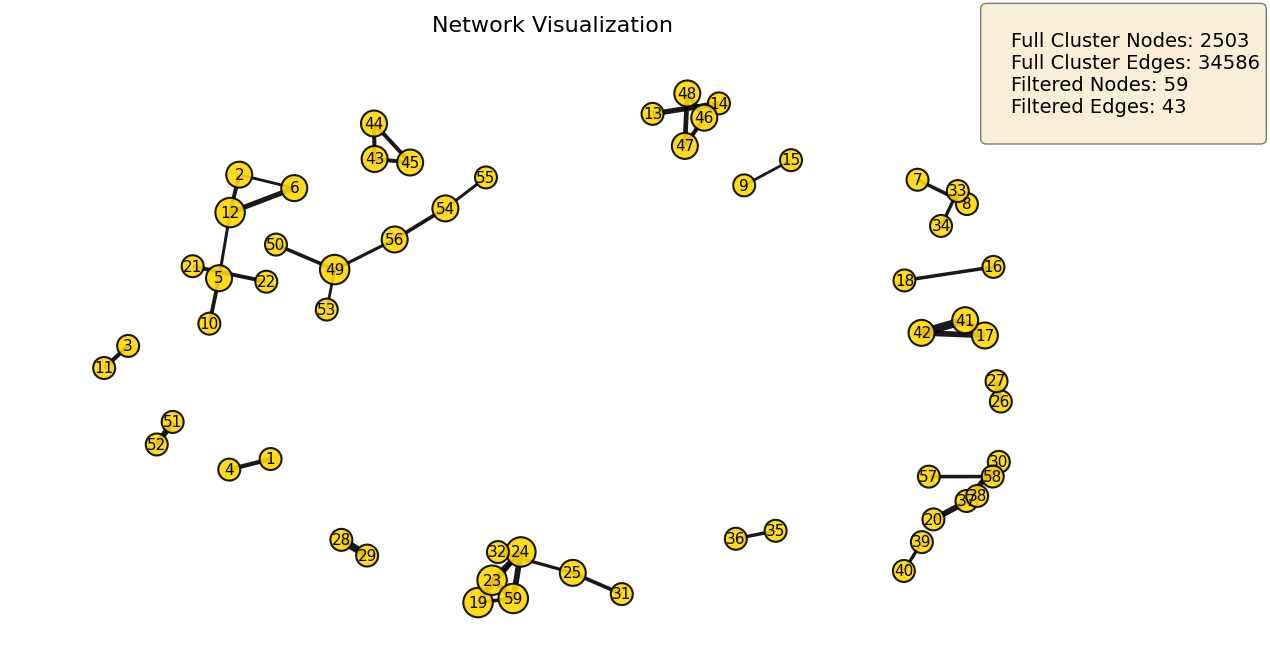

,Omic,Degree
Index,,
59,hsa_mir_767,3
24,hsa_mir_105_2,3
23,hsa_mir_105_1,3
12,SNORD80,3
19,MAGEA6_4105,3
49,hsa_mir_516a_1,3
17,CDC20B_166979,2
2,SNORD4A,2
41,hsa_mir_449a,2


In [ ]:
# Combine each omics modality into a single multi-omics dataframe
# Let's select the top 1000 featurs from RNA and Methylation. (6000 -> 500 features).
from bioneuralnet.utils import select_top_k_variance

brca_meth = select_top_k_variance(brca_meth, k=1000)
brca_rna = select_top_k_variance(brca_rna, k=1000)

merged_brca = pd.concat([brca_meth, brca_rna, brca_mirna], axis=1)

# Build cosine-similarity network
sim_network_brca = gen_similarity_graph(merged_brca, k=15, metric="cosine")
print("similarity_cosine shape:", sim_network_brca.shape)
nodes_df = plot_network(sim_network_brca, weight_threshold=0.0895, show_labels=True, layout="spring")
display(nodes_df.head(10))


# node_table is a DataFrame with node IDs ("Omics") and their degrees, you can save it and the network for later analysis:
# similarity_network.to_csv("brca_similarity_network.csv")
# node_table.to_csv("brca_network_node_degrees.csv", index=False)

correlation_spearman shape: (2503, 2503)


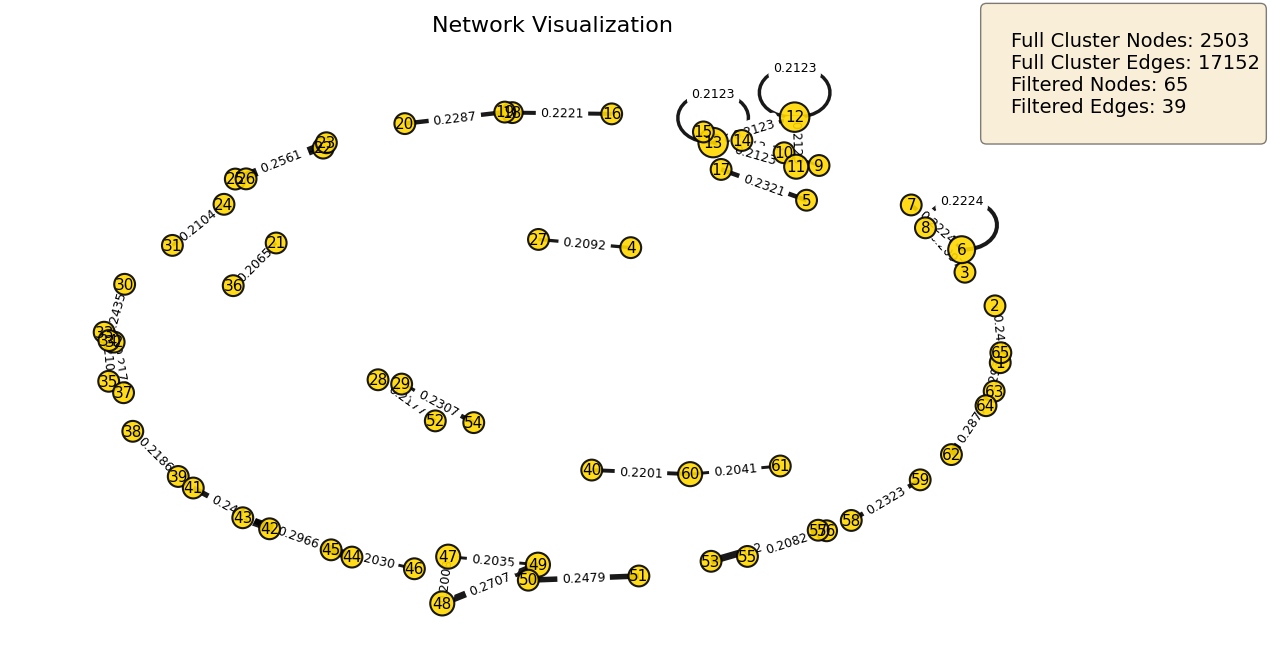

,Omic,Degree
Index,,
12,SNAR_C2,4


,Omic,Degree
Index,,
48,hsa_mir_194_1,2


In [ ]:
# Correlation Network
corr_network_brca = gen_correlation_graph(merged_brca, k=8, method="spearman")
print("correlation_spearman shape:", corr_network_brca.shape)
nodes_df = plot_network(corr_network_brca, weight_threshold=0.1998, show_edge_weights=True, show_labels=True, layout="kamada")

# We can use the label to see the number of edges at this omics/node
display(nodes_df.loc[[12]])
display(nodes_df.loc[[48]])

soft_threshold shape: (2503, 2503)


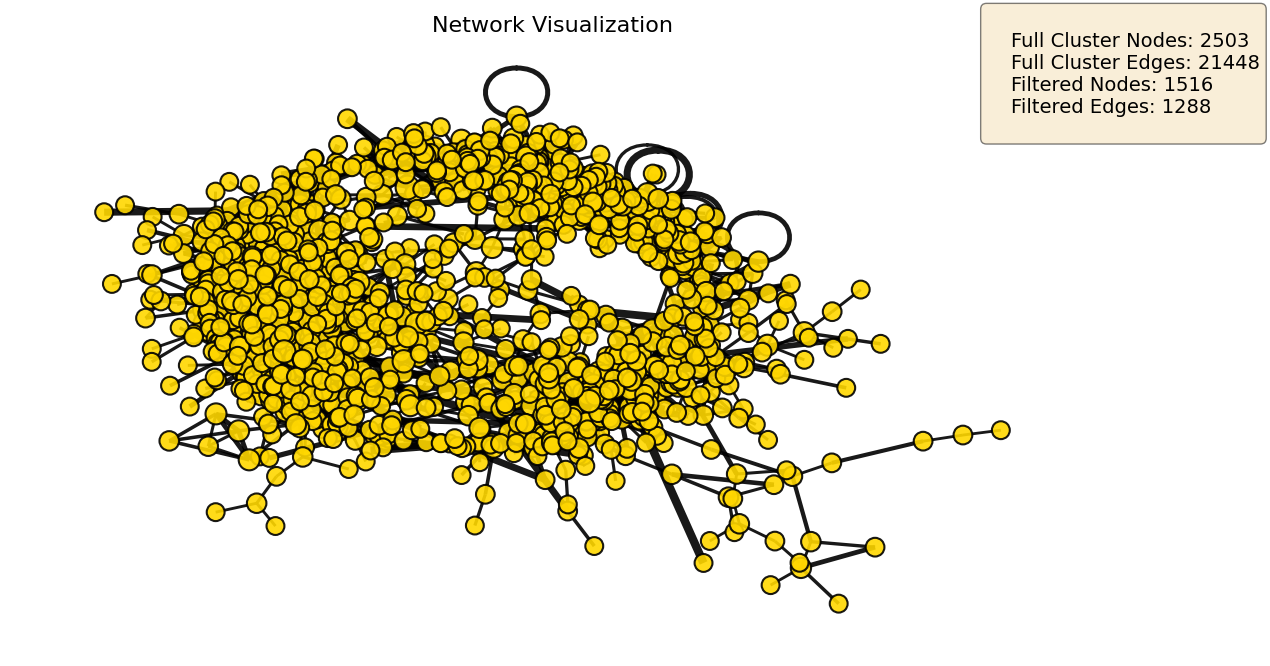

,Omic,Degree
Index,,
524,ROPN1_54763,19
589,SFRP1_6422,12
507,PGR_5241,11
1341,hsa_mir_3647,9
502,CYP4Z2P_163720,9
688,CLDN19_149461,8
449,PIP_5304,8
537,NEK10_152110,8
1368,hsa_mir_379,7


In [ ]:
# Soft-threshold Network
soft_network_brca = gen_threshold_graph(merged_brca, b=6, k=10)
print("soft_threshold shape:", soft_network_brca.shape)
nodes_map = plot_network(soft_network_brca, weight_threshold=0.15, show_labels=False)
display(nodes_map.head())

# At times a dense graph may be difficult to visualize, but the network plot still provides useful information.
"""
Omic          Degree
ROPN1_54763     19
SFRP1_6422      12
PGR_5241        11
hsa_mir_3647     9
CYP4Z2P_163720   9
"""

(2503, 2503)


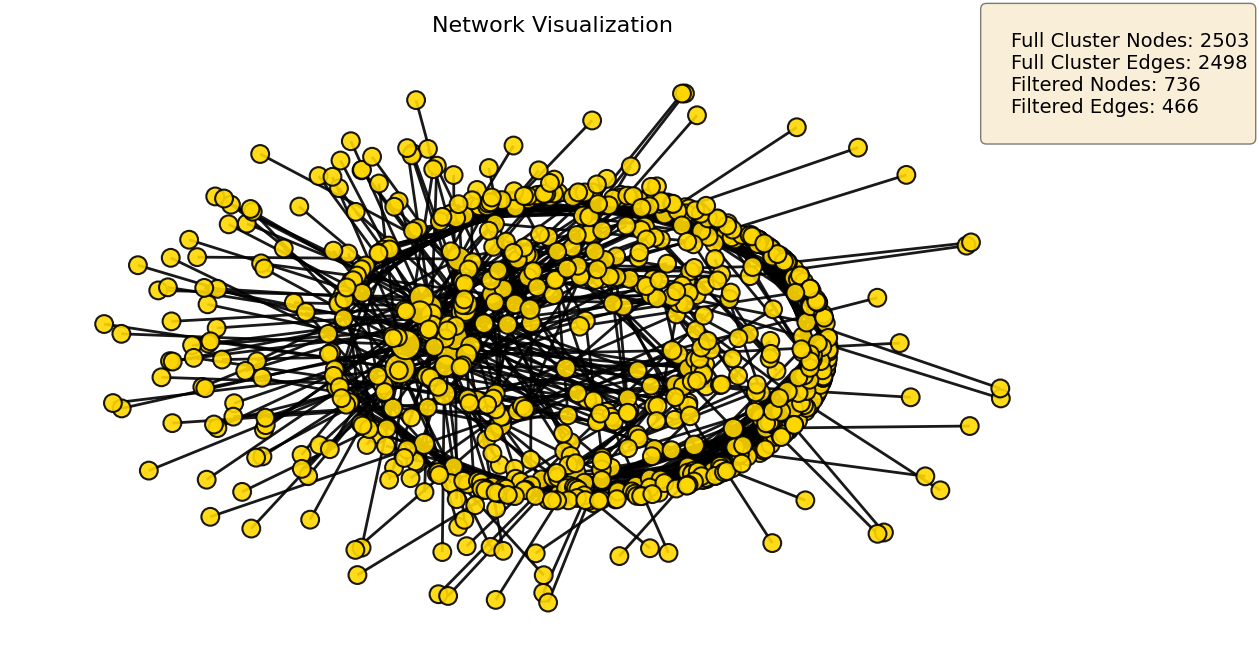

,Omic,Degree
Index,,
47,REP15,21
115,MIR1280,20
147,ASF1A,14
64,MIR198,10
99,HGC6.3,10


In [ ]:
# Minimum Spanning Tree
mst_network_brca = gen_mst_graph(merged_brca)
print(mst_network_brca.shape)
nodes_df = plot_network(mst_network_brca, weight_threshold=0.95, show_labels=False)
display(nodes_df.head())

(2503, 2503)


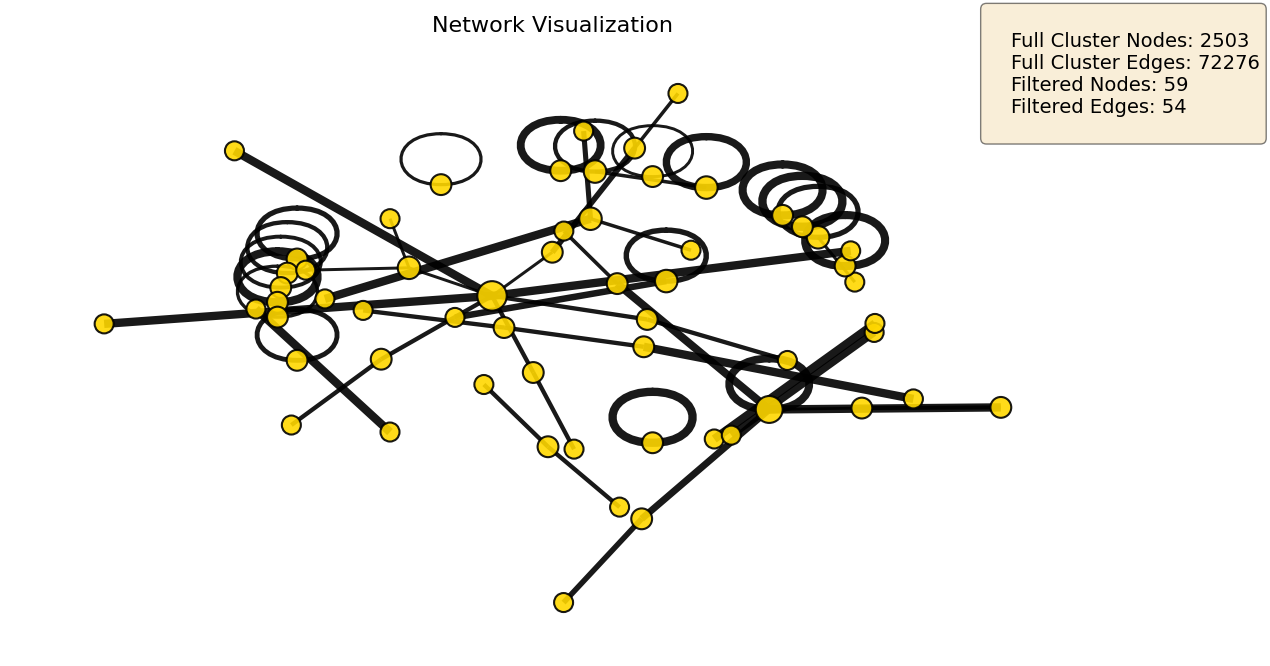

,Omic,Degree
Index,,
37,ROPN1_54763,8
50,hsa_mir_301b,6
22,FAM74A3,3
15,OR2J3,3
5,LOC100130331,3


In [861]:
# Shared Nearest Neighbor
snn_network_brca = gen_snn_graph(merged_brca, k=30)
print(snn_network_brca.shape)
nodes_df = plot_network(snn_network_brca, weight_threshold=0.3005, show_edge_weights=False)
display(nodes_df.head())